In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from code_utils.read_ipcc_bib import read_bib_wg
from code_utils.enriching_data_OpenAlex import get_countries_concepts_sdg,get_open_alex_data,get_open_alex_data_not_in_references
from code_utils.utils import aplatir,wg_chap_to_dict,get_doi_cleaned
from code_utils.pickle import load_cache,write_cache

In [2]:
cached_openalex_data = {}
cached_openalex_data_not_ipcc = {}

In [3]:
try:
    cached_openalex_data = load_cache(cached_openalex_data,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data.pkl')
    cached_openalex_data_not_ipcc = load_cache(cached_openalex_data_not_ipcc,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipcc.pkl')
except:
    #write_cache(cached_openalex_data,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data.pkl')
    #write_cache(cached_openalex_data_not_ipcc,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipcc.pkl')
    print('oups not in bibliography folder')

53358 data in cached openalex data
98 data in cached openalex data


In [ ]:
#write_cache(cached_openalex_data,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data.pkl')
#write_cache(cached_openalex_data_not_ipcc,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipcc.pkl')

Read IPCC references in .bib files

In [ ]:
wgs={'1':{'wg1':[], 'dataframes_1':{}, 'listdir1':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG1")},
     '2':{'wg2':[], 'wg2_update':[], 'dataframes_2':{}, 'listdir2':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG2")},
     '2_CROSS':{'wg2_CROSS':[], 'wg2_CROSS_update':[], 'dataframes_2_CROSS':{}, 'listdir2_CROSS':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG2_CROSS")},
     '3':{'wg1':[], 'dataframes_3':{}, 'listdir3':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG3")}}

In [ ]:
for k in ['1','2','2_CROSS','3']:
    wgs[k][f'df_{k}'] = read_bib_wg(wgs,k,verbose=True)
    print(wgs[k][f'wg{k}_update'])
    #wgs[k][f'df_{k}'].to_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_wg{k}.jsonl', orient='records', lines=True)

Read and clean the data from 'structured_data' folder

In [43]:
data_all={}

In [44]:
for k in ['1','2','2_CROSS','3']:
   data_all[f'df_wg{k}']=pd.read_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_wg{k}.jsonl', lines= True)

In [45]:
#all data 
df_ipcc=pd.concat(list(data_all.values()), ignore_index=True)

In [46]:
df_ipcc.loc[:,'doi']=df_ipcc.loc[:,'doi'].apply(lambda x: get_doi_cleaned(x))
df_ipcc.loc[:,'doi']=df_ipcc.loc[:,'doi'].apply(lambda x: None if str(x)[:4]=='http' else x)
df_ipcc['freq']=1

Enriching data through OpenAlex API integration

In [8]:
df_unique_doi=df_ipcc.groupby(by=['year','doi','title','author'], dropna=True).agg({'wg': lambda x: list(x),'chap': lambda x: list(x), 'freq': 'sum'})

In [9]:
df_unique_doi=df_unique_doi.reset_index()

In [10]:
#get data_OpenAlex from the API 
df_unique_doi.apply(lambda row: get_open_alex_data(cached_openalex_data,row['doi']), axis= 1)

0        [{'id': 'https://openalex.org/W4244279015', 'd...
1        [{'id': 'https://openalex.org/W4252425265', 'd...
2        [{'id': 'https://openalex.org/W3091998362', 'd...
3        [{'id': 'https://openalex.org/W2314134964', 'd...
4        [{'id': 'https://openalex.org/W256209766', 'do...
                               ...                        
64978    [{'id': 'https://openalex.org/W3208727233', 'd...
64979    [{'id': 'https://openalex.org/W3153808443', 'd...
64980    [{'id': 'https://openalex.org/W3193073190', 'd...
64981    [{'id': 'https://openalex.org/W2983893943', 'd...
64982    [{'id': 'https://openalex.org/W3102655557', 'd...
Length: 64983, dtype: object

In [11]:
len(cached_openalex_data)

53358

In [ ]:
write_cache(cached_openalex_data,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data.pkl')

In [12]:
countries_list = []
concepts_list = []
sdg_list = []
topics_list = []
is_OA_available_list=[]
title_list=[]

for i,row in df_unique_doi.iterrows():
    countries,concepts,sdg,year,topics,doi,bool_OA,title=get_countries_concepts_sdg(cached_openalex_data,row)

    countries_list.append(countries)
    concepts_list.append(concepts)
    sdg_list.append(sdg)
    topics_list.append(topics)
    is_OA_available_list.append(bool_OA)
    title_list.append(title)
    

df_unique_doi['countries'] = countries_list
df_unique_doi['concepts'] = concepts_list
df_unique_doi['sdg'] = sdg_list
df_unique_doi['topics'] = topics_list
df_unique_doi['is_OA_available'] = is_OA_available_list
df_unique_doi['title_OA'] = title_list

In [13]:
df_unique_doi['wg_chap']=df_unique_doi.apply(lambda row: wg_chap_to_dict(row), axis=1)

In [40]:
dd=df_unique_doi[df_unique_doi.is_OA_available]
dd=dd.dropna(subset=['doi']).groupby(['doi']).agg({'wg_chap': lambda x: aplatir(list(x)),'countries':lambda x: list(x)[0],'topics':lambda x: list(x)[0],'title_OA':lambda x: list(x)[0]}).reset_index()

In [47]:
df_ipcc=df_ipcc[['year', 'url', 'doi', 'author']]

Visualization of the contribution of each countries in ipcc references

In [48]:
df_ipcc=pd.merge(df_ipcc, dd, on='doi', how='inner')

In [49]:
df_ipcc.loc[:,'countries']=df_ipcc.loc[:,'countries'].apply(lambda x: str(x).replace('nan','None').replace('[]','None').replace('[None]','None') if ((str(x)=='nan')|(str(x)=='[None]')|((str(x)=='[]'))) else x )
df_ipcc.loc[:,'countries']=df_ipcc.loc[:,'countries'].apply(lambda x: ['None'] if x=='None' else x)

In [ ]:
df_ipcc.to_json(module_path+'\\IPCC_bibliography\\AR6\\structured_data\\data_ipcc_visualization.json', orient='records')

In [22]:
data_counts = pd.Series(aplatir(list(df_ipcc['countries']))).value_counts().drop('None')

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\haallat\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\haallat\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\ha

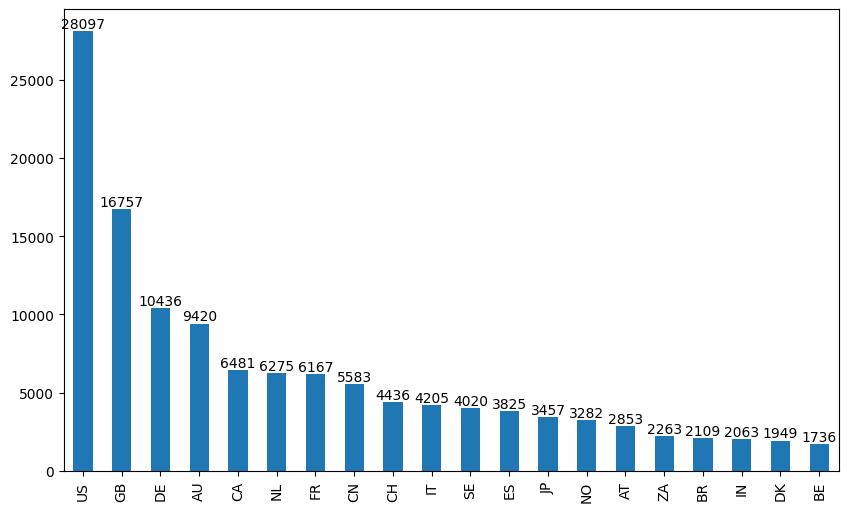

In [23]:
plt.figure(figsize=(10, 6))
data_counts[:20].plot(kind='bar')
ax = data_counts[:20].plot(kind='bar')
for i, v in enumerate(data_counts[:20]):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.show()

Find the data for constructing the learning model ( IPCC related or not )

In [ ]:
#pd.Series([x[0].get('name').lower().replace('-',' ') for x in list(df_ipcc.topics.dropna())]).value_counts()[75:100]

In [ ]:
df_ipcc=pd.read_json(module_path+'\\IPCC_bibliography\\AR6\\structured_data\\data_ipcc_visualization.json')

In [ ]:
df_ipcc['year'] = pd.to_numeric(df_ipcc['year'], errors='coerce')
year=df_ipcc.drop_duplicates(subset='doi')['year'].dropna().sort_values().apply(lambda x: int(x))
year_counts = pd.Series(list(year)).value_counts().to_dict()
del year_counts[202]

In [ ]:
dois=list(df_ipcc.doi.dropna().drop_duplicates())
year_counts_not_ipcc={}

In [ ]:
for year in list(year_counts.keys()):   
    cached_openalex_data_not_ipcc[year]=[]
    year_counts_not_ipcc[year]=0
    while year_counts_not_ipcc[year]<year_counts[year]:
        get_open_alex_data_not_in_references(dois,cached_openalex_data_not_ipcc,year_counts,year_counts_not_ipcc,year)
    cached_openalex_data_not_ipcc[year]=cached_openalex_data_not_ipcc[year][:year_counts[year]+1]

In [24]:
len(cached_openalex_data_not_ipcc)

98

In [ ]:
write_cache(cached_openalex_data_not_ipcc,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipcc.pkl')

In [26]:
df_not_ipcc=pd.DataFrame()
year_list = []
countries_list = []
concepts_list = []
sdg_list = []
topics_list = []
dois_list = []
title_list=[]
for k in range(len(aplatir(list(cached_openalex_data_not_ipcc.values())))):
    countries,concepts,sdg,year,topics,doi,bool_OA,title=get_countries_concepts_sdg(cached_openalex_data=aplatir(list(cached_openalex_data_not_ipcc.values())),ipcc=False,i=k)

    countries_list.append(countries)
    concepts_list.append(concepts)
    sdg_list.append(sdg)
    year_list.append(year)   
    topics_list.append(topics)   
    dois_list.append(doi)
    title_list.append(title)   

df_not_ipcc['countries'] = countries_list
df_not_ipcc['concepts'] = concepts_list
df_not_ipcc['sdg'] = sdg_list
df_not_ipcc['year'] = year_list
df_not_ipcc['topics'] = topics_list
df_not_ipcc['doi'] = dois_list
df_not_ipcc['title_OA'] = title_list

In [27]:
df_not_ipcc.to_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_not_ipcc.jsonl', orient='records', lines= True)

In [ ]:
df_ipcc